<a href="https://colab.research.google.com/github/Piligrimich/Piligrimich/blob/main/CIFAR10_with_Ray_Tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import torchvision.datasets as dset
import matplotlib.pyplot as plt

from torchvision import transforms

from torch.utils.data.sampler import SubsetRandomSampler

#from torchvision import d


In [ ]:
transforms = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))    
])

data_train = dset.CIFAR10('./',train=True,download=True,transform=transforms)

data_test = dset.CIFAR10('./',train=False,download=True,transform=transforms)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [ ]:
data_train.data.shape

(50000, 32, 32, 3)

In [ ]:
all_classes = data_train.classes

In [ ]:
batch_size = 64

train_size = data_train.data.shape[0]
validation_split = .2

split = int(np.floor(train_size*validation_split))
indices = list(range(train_size))

np.random.shuffle(indices)

train_indices,val_indices = indices[split:],indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train,batch_size=batch_size,sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train,batch_size=batch_size,sampler=val_sampler)


In [ ]:
class CIFARModel(nn.Module):
  def __init__(self):
    super(CIFARModel,self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=12, stride=4, padding=4),# 7*7*64
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2), # 3*3*64
        nn.Conv2d(64, 192, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.avgpool = nn.AdaptiveAvgPool2d((6,6))
    self.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(256*6*6,4096),
        nn.ReLU(inplace=True),
        nn.Dropout(.5),
        nn.Linear(4096,4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096,10)
    )
  def forward(self,x):
    x = self.features(x),
    x = self.avgpool(x),
    x = self.flatten(x,1),
    x = self.classifier(x)
    return x

In [ ]:
class LeNetModel(nn.Module):
  def __init__(self):
    super(LeNetModel,self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3,6,5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Conv2d(6,16,5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.BatchNorm2d(16)
    )
    self.classifier = nn.Sequential(
        nn.Linear(16*5*5,120),
        nn.BatchNorm1d(120),
        nn.Dropout(.5),
        nn.ReLU(),
        nn.Linear(120,84),
        nn.BatchNorm1d(84),
        nn.Dropout(.2),
        nn.ReLU(),
        nn.Linear(84,10)
    )
  def forward(self,x):
    x = self.features(x)
    x = torch.flatten(x,1) # или x = x.view(x.size(0),-1)
    x = self.classifier(x)
    return x

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3,6,5),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(6,16,5),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
    )
    self.classifier = nn.Sequential(
        nn.Linear(16*5*5,l1),
        nn.ReLU(),
        nn.Linear(l1,l2),
        nn.ReLU(),
        nn.Linear(l2,10)
    )
  def forward(self,x):
    x = self.features(x)
    x = torch.flatten(x,1)
    x = self.classifier(x)
    return x
  

In [ ]:
def fit(train_loader,val_loader,loss,optimizer,num_epochs):
  model = Net(config["l1"],config["l2"])
  model.to(device)

  loss = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(),lr=config["lr"],momentum=0.9)
  for epoch in range(num_epochs):
    model.train()
    correct_samples = 0
    total_samples = 0
    loss_sum = 0
    for i_step, (x,y) in enumerate(train_loader):
      x,y = x.to(device),y.to(device)
      outputs = model(x)
      loss_value = loss(outputs,y)
      optimizer.zero_grad()
      loss_value.backward()
      optimizer.step()

      _,indices = torch.max(outputs,dim=1)
      correct_samples += torch.sum(indices == y)
      total_samples += y.shape[0]
      loss_sum += loss_value
    val_accuracy = validationAccuracy(model,val_loader)
    print("Epoch: %f  Accuracy %f  Val accuracy %f "%(epoch+1,(correct_samples/total_samples),val_accuracy))


def validationAccuracy(model,val_loader):
  model.eval()
  correct_samples = 0
  total_samples = 0
  for i_step,(x,y) in enumerate(val_loader):
    x,y = x.to(device),y.to(device)
    predicts = model(x)

    
    _, indices = torch.max(predicts,dim=1)
    correct_samples += torch.sum(indices == y)
    total_samples += y.shape[0]

  return correct_samples/total_samples

In [ ]:
device = torch.device('cuda:0')
print(device)

cuda:0


In [ ]:
#model = CIFARModel()
model = LeNetModel()
#model = Net()
#model.type(torch.cuda.FloatTensor)
model.to(device)

LeNetModel(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=84, bias=True)
    (5): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
loss = nn.CrossEntropyLoss()#.type(torch.cuda.FloatTensor)
#optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [ ]:
def fit(model,train_loader,val_loader,loss,optimizer,num_epochs):
  
  for epoch in range(num_epochs):
    model.train()
    correct_samples = 0
    total_samples = 0
    loss_sum = 0
    for i_step, (x,y) in enumerate(train_loader):
      x,y = x.to(device),y.to(device)
      outputs = model(x)
      loss_value = loss(outputs,y)
      optimizer.zero_grad()
      loss_value.backward()
      optimizer.step()

      _,indices = torch.max(outputs,dim=1)
      correct_samples += torch.sum(indices == y)
      total_samples += y.shape[0]
      loss_sum += loss_value
    val_accuracy = validationAccuracy(model,val_loader)
    print("Epoch: %f  Accuracy %f  Val accuracy %f "%(epoch+1,(correct_samples/total_samples),val_accuracy))


def validationAccuracy(model,val_loader):
  model.eval()
  correct_samples = 0
  total_samples = 0
  for i_step,(x,y) in enumerate(val_loader):
    x,y = x.to(device),y.to(device)
    predicts = model(x)

    
    _, indices = torch.max(predicts,dim=1)
    correct_samples += torch.sum(indices == y)
    total_samples += y.shape[0]

  return correct_samples/total_samples

In [ ]:
def imagePrint(model, data):
  
  for x,y in data:
    x = x.to(device)
    pred = model(x)
    
    for i in range(6):
      plt.subplot(2,6,i+1)
      plt.imshow(y[i])
      plt.title(pred[i])

In [ ]:
for x,y in val_loader:
    x = x.to(device)
    pred = model(x)
    _,indices = torch.max(pred,dim=1)
    x = x.to('cpu')
    for i in range(6):
      #print(f'На картинке написа'indices[i].to('cpu').detach().numpy())
      #print(y[i].detach().numpy())
      print(f'сеть думает тут {all_classes[indices[i]]}')
      x[i] = x[i] /2+0.5
      img = x[i].permute(1,2,0).detach().numpy()
      plt.subplot(5,5,i+1)
      plt.imshow(img)
      plt.title(all_classes[y[i]])
      plt.show()
      #print(x[i])'''

      

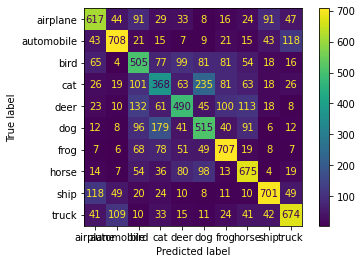

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

batch_size = 64

data_size = data_test.data.shape[0]

indices = list(range(data_size))
np.random.shuffle(indices)

test_sampler = SubsetRandomSampler(indices)
test_loader = torch.utils.data.DataLoader(data_test,batch_size = batch_size,sampler = test_sampler)
#X,Y = data_test.data,data_test.target

#print(X.shape)

actual_data = []
predicted_data = []
for X,Y in test_loader:
  X = X.to(device)
  #print(X.shape)
  pred = model(X)
  _,indices = torch.max(pred,dim=1)
  indices = indices.to('cpu')
  indices = indices.detach().numpy()
  Y = Y.detach().numpy()
  for i in range(len(X)):
    actual_data.append(Y[i])
    predicted_data.append(indices[i])

#print("actual_data",len(actual_data))
#print("predicted_data",len(predicted_data))

cm = confusion_matrix(actual_data,predicted_data)

cmd_obj = ConfusionMatrixDisplay(cm,display_labels=all_classes)
cmd_obj.plot()
#cmd_obj.show()

In [ ]:
data_test.data.shape[0]

10000

In [ ]:
data_test.targets

In [ ]:
fit(model,train_loader,val_loader,loss,optimizer,50)

Epoch: 1.000000  Accuracy 0.662025  Val accuracy 0.658300 
Epoch: 2.000000  Accuracy 0.661425  Val accuracy 0.658000 


KeyboardInterrupt: ignored

In [ ]:
fit(model,train_loader,val_loader,loss,optimizer,5)

Epoch: 1.000000  Accuracy 0.606900  Val accuracy 0.632900 
Epoch: 2.000000  Accuracy 0.608825  Val accuracy 0.630000 
Epoch: 3.000000  Accuracy 0.613425  Val accuracy 0.633500 
Epoch: 4.000000  Accuracy 0.613175  Val accuracy 0.632500 
Epoch: 5.000000  Accuracy 0.618400  Val accuracy 0.637900 


In [ ]:
fit(model,train_loader,val_loader,loss,optimizer,5)

Epoch: 1.000000  Accuracy 0.106700  Val accuracy 0.106700 
Epoch: 2.000000  Accuracy 0.104225  Val accuracy 0.107400 
Epoch: 3.000000  Accuracy 0.108775  Val accuracy 0.106900 
Epoch: 4.000000  Accuracy 0.108500  Val accuracy 0.107200 
Epoch: 5.000000  Accuracy 0.106450  Val accuracy 0.108000 


In [ ]:
fit(model,train_loader,val_loader,loss,optimizer,5)# Adam + Net()

Epoch: 0.000000  Accuracy 0.100125  Val accuracy 0.099500 
Epoch: 1.000000  Accuracy 0.100125  Val accuracy 0.099500 
Epoch: 2.000000  Accuracy 0.100125  Val accuracy 0.099500 
Epoch: 3.000000  Accuracy 0.100125  Val accuracy 0.099500 
Epoch: 4.000000  Accuracy 0.100125  Val accuracy 0.099500 


In [ ]:
fit(model,train_loader,val_loader,loss,optimizer,5)# SGD + Net()

Epoch: 0.000000  Accuracy 0.100175  Val accuracy 0.099500 
Epoch: 1.000000  Accuracy 0.100175  Val accuracy 0.099500 
Epoch: 2.000000  Accuracy 0.100175  Val accuracy 0.099500 
Epoch: 3.000000  Accuracy 0.100175  Val accuracy 0.099500 
Epoch: 4.000000  Accuracy 0.100175  Val accuracy 0.099500 


In [ ]:
fit(model,train_loader,val_loader,loss,optimizer,5)# SGD(momentum) + Net()

Epoch: 1.000000  Accuracy 0.100425  Val accuracy 0.098300 
Epoch: 2.000000  Accuracy 0.100425  Val accuracy 0.098300 
Epoch: 3.000000  Accuracy 0.100425  Val accuracy 0.098300 
Epoch: 4.000000  Accuracy 0.100425  Val accuracy 0.098300 
Epoch: 5.000000  Accuracy 0.100425  Val accuracy 0.098300 


In [ ]:
fit(model,train_loader,val_loader,loss,optimizer,5) #SGD + LeNetModel()

Epoch: 0.000000  Accuracy 0.101400  Val accuracy 0.095100 
Epoch: 1.000000  Accuracy 0.099725  Val accuracy 0.097100 
Epoch: 2.000000  Accuracy 0.100225  Val accuracy 0.096800 
Epoch: 3.000000  Accuracy 0.100975  Val accuracy 0.098800 
Epoch: 4.000000  Accuracy 0.098500  Val accuracy 0.097300 


In [ ]:
fit(model,train_loader,val_loader,loss,optimizer,5) #SGD(momentum) + LeNetModel()

Epoch: 0.000000  Accuracy 0.098550  Val accuracy 0.097000 
Epoch: 1.000000  Accuracy 0.100600  Val accuracy 0.098500 
Epoch: 2.000000  Accuracy 0.097675  Val accuracy 0.094700 
Epoch: 3.000000  Accuracy 0.098500  Val accuracy 0.095300 
Epoch: 4.000000  Accuracy 0.097875  Val accuracy 0.095300 


In [ ]:
fit(model,train_loader,val_loader,loss,optimizer,5) #SGD(momentum) + LeNetModel()

Epoch: 1.000000  Accuracy 0.383700  Val accuracy 0.460600 
Epoch: 2.000000  Accuracy 0.430725  Val accuracy 0.480200 
Epoch: 3.000000  Accuracy 0.455350  Val accuracy 0.505400 
Epoch: 4.000000  Accuracy 0.477400  Val accuracy 0.531800 
Epoch: 5.000000  Accuracy 0.489450  Val accuracy 0.537400 
